In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("241129_전처리.csv")
df.fillna("내용 없음", inplace = True)

EDA = df.copy()

In [3]:
summary = df["줄거리"]
summary.tolist()
title = df["제목"]
title.tolist()
print(summary)

0        개인용 첨단장비 개발의 권위자 차준혁. 첫사랑을 구하기 위해 히어로가 된다. 무기가...
1        재능이 없으면 굴러라!  인생의 메인 퀘스트의 보상은 ‘죽음’이리라.  무능력한 자...
2        에피루스 베스트 무협 소설!  전설적인 무신 염백우라는 사람이 온갖 귀한 것들만 모...
3        <강추!>매사에 긍정적인 밝은 성격과 재벌집 아가씨답지 않은 소박함을 가진 스무 살...
4        원나잇은 OK, 사랑은 NO!  유학 시절 지고지순하게 사랑했던 남자에게 배신당한 ...
                               ...                        
13074    유진산 퓨전 무협 장편소설 『철자검』   철자검, 그 속에 숨겨진 진실된 비밀은 두...
13075    우리가 아는 것과 다른 역사. 동북아시아의 강자가 된 조선 이야기. 병자호란에서 패...
13076    “돈으로 팔린다는 게 이런 거다. 아니, 이것보다 더 하지.  그럼 다시 묻는다. ...
13077    거대 행성의 충돌 후, 지구에 두 개의 세계가 공존하기 시작했다. 몬스터의 출현과 ...
13078    화산의 대사형 진자강  파문제자가 되어 내침을 당하다!   "가지고자 하는 자, 삼...
Name: 줄거리, Length: 13079, dtype: object


In [4]:
from transformers import AutoModel, AutoTokenizer
model = AutoModel.from_pretrained("monologg/kobert")
tokenizer = AutoTokenizer.from_pretrained("monologg/kobert", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
from tqdm import tqdm

def embed_sentences(sentences, model, tokenizer, device="cuda", method="cls"):
    # 모델을 지정한 디바이스로 이동
    model = model.to(device)
    model.eval()

    # 입력 문장을 토큰화
    tokenized = tokenizer(
        sentences,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)  # 토큰화된 데이터를 지정한 디바이스로 이동

    # 모델에서 출력 얻기
    with torch.no_grad():
        outputs = model(**tokenized)
        hidden_states = outputs.last_hidden_state  # (N x seq_len x hidden_size)

    # 문장 벡터 추출
    if method == "cls":
        # [CLS] 토큰의 벡터 사용 (첫 번째 토큰)
        sentence_embeddings = hidden_states[:, 0, :]  # (N x hidden_size)
    elif method == "mean":
        # 패딩되지 않은 토큰 벡터의 평균값 사용
        attention_mask = tokenized["attention_mask"]  # (N x seq_len)
        expanded_mask = attention_mask.unsqueeze(-1).expand(hidden_states.size())
        sum_hidden_states = torch.sum(hidden_states * expanded_mask, dim=1)
        sum_mask = torch.sum(attention_mask, dim=1).unsqueeze(-1)
        sentence_embeddings = sum_hidden_states / sum_mask  # (N x hidden_size)
    else:
        raise ValueError("method must be either 'cls' or 'mean'")

    return sentence_embeddings

device = "cuda" if torch.cuda.is_available() else "cpu"

embeddings_summary = torch.empty((0, 768)).to(device)
embeddings_title = torch.empty((0, 768)).to(device)

for i in tqdm(range(len(summary)), desc="Summary Embedding Progress"):
    embedded = embed_sentences([summary[i]], model, tokenizer, device=device, method="cls")
    embeddings_summary = torch.cat((embeddings_summary, embedded), dim=0)

for i in tqdm(range(len(title)), desc="Title Embedding Progress"):
    embedded = embed_sentences([title[i]], model, tokenizer, device=device, method="cls")
    embeddings_title = torch.cat((embeddings_title, embedded), dim=0)

print("임베딩 크기:", embeddings_summary.shape)  # (N x hidden_size)
print("임베딩:", embeddings_summary[0])

Title Embedding Progress: 100%|██████████| 13079/13079 [02:30<00:00, 87.06it/s]


임베딩 크기: torch.Size([13079, 768])
임베딩: tensor([-3.3619e-02,  3.0062e-01,  1.8700e-01, -5.5226e+00, -2.7613e-02,
         3.3887e-03,  2.4410e-01,  9.8682e-02, -1.2299e+00, -8.9377e-02,
        -4.7660e-01,  3.8742e-01, -7.3255e-02, -1.7226e-01,  8.8714e-02,
        -8.5336e-02, -1.6196e-01, -7.0290e-02,  4.1337e-03, -2.4946e-01,
        -4.6764e-01, -2.8386e-01, -1.3138e-01, -8.1603e-02, -4.3372e-01,
         1.7881e-01, -2.6839e-01, -1.1687e-01, -6.3174e-02, -1.7771e-01,
         1.5837e-01,  9.9873e-02,  4.3753e-01,  2.5195e-01,  1.1802e-01,
        -2.3360e-01,  1.7476e-01,  1.4372e-01,  5.2022e-02,  7.3644e-02,
         3.7787e-01, -1.3338e-01, -8.7623e-02, -5.9163e-01,  4.2472e-02,
         2.9077e-01, -6.2820e-02, -8.0765e-02,  5.3126e-01,  2.5252e-01,
        -1.5226e-01,  6.1038e-01,  2.9568e-01, -5.0115e-02,  2.5353e-01,
        -2.0117e-01,  2.3849e-01, -1.9060e-01, -2.7211e-01, -4.6841e-03,
        -1.4063e-01, -2.7202e-01, -1.4238e-01, -1.8420e-01,  5.3436e-01,
        -1.75

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 임베딩 데이터 (예시: embeddings)
embeddings_np_summary = embeddings_summary.cpu().numpy()  # GPU에서 CPU로 이동 (필요 시)

# # 클러스터 개수 범위 설정
# cluster_range = range(1, 50)
# inertia_values = []

# # 각 클러스터 개수에 대해 K-means 실행
# for k in tqdm(cluster_range, desc = "클러스터링"):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(embeddings_np_summary)
#     inertia_values.append(kmeans.inertia_)  # 관성 값 저장

# # 엘보우 그래프 시각화
# plt.figure(figsize=(8, 6))
# plt.plot(cluster_range, inertia_values, marker='o', linestyle='--')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal k (Summary)')
# plt.xticks(cluster_range, rotation = 90)
# plt.grid()
# plt.show()
"""
결과적으로 10
"""

'\n결과적으로 10\n'

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 임베딩 데이터 (예시: embeddings)
embeddings_np_title = embeddings_title.cpu().numpy()  # GPU에서 CPU로 이동 (필요 시)

# # 클러스터 개수 범위 설정
# cluster_range = range(1, 50)
# inertia_values = []

# # 각 클러스터 개수에 대해 K-means 실행
# for k in tqdm(cluster_range, desc = "클러스터링"):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(embeddings_np_title)
#     inertia_values.append(kmeans.inertia_)  # 관성 값 저장

# # 엘보우 그래프 시각화
# plt.figure(figsize=(8, 6))
# plt.plot(cluster_range, inertia_values, marker='o', linestyle='--')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal k (Title)')
# plt.xticks(cluster_range, rotation = 90)
# plt.grid()
# plt.show()

"""
결과적으로 8
"""

'\n결과적으로 8\n'

In [8]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters_summary = kmeans.fit_predict(embeddings_np_summary)

In [9]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters_title = kmeans.fit_predict(embeddings_np_title)

In [10]:
df['줄거리'] = clusters_summary
df['제목'] = clusters_title

EDA['줄거리'] = clusters_summary
EDA['제목'] = clusters_title

In [11]:
from sklearn.preprocessing import LabelEncoder

cats = ['장르', '작가', '출판사', '연령제한', '연관콘텐츠']
label_encoder = LabelEncoder()

# 각 열에 대한 dictionary를 저장할 딕셔너리
category_mappings = {}

# '장르', '작가', '출판사' 열에 대해 인코딩
for col in cats:
    df[col + '_encoded'] = label_encoder.fit_transform(df[col])

    # 인코딩 매핑을 dictionary로 저장
    category_mappings[col] = {index: label for index, label in enumerate(label_encoder.classes_)}

# 결과 출력
for col, mapping in category_mappings.items():
    print(f"'{col}'의 인코딩 매핑:")
    print(mapping)


'장르'의 인코딩 매핑:
{0: 'BL', 1: '라이트노벨', 2: '로맨스', 3: '로판', 4: '무협', 5: '미스터리', 6: '판타지', 7: '현판'}
'작가'의 인코딩 매핑:
{0: '10000LAB', 1: '287000', 2: '303행성', 3: '3B연필', 4: '5月돼지', 5: '6號戰車Tiger', 6: '6호전차Tiger', 7: '7월', 8: '7월아카이브', 9: 'AKARU', 10: 'ALLA', 11: 'ATK', 12: 'Abyss사서', 13: 'AkiKenta', 14: 'Althaea', 15: 'Arisa Maki', 16: 'A사과', 17: 'BC', 18: 'BK', 19: 'BLACK', 20: 'BSol', 21: 'Benecia', 22: 'Boot붓', 23: 'CHOJJA', 24: 'CP', 25: 'CatReading', 26: 'Cielinto', 27: 'Daniel Lyan', 28: 'Dientes', 29: 'DoBerry', 30: 'E.rang', 31: 'ERICKA', 32: 'El Luth Fosus', 33: 'Er Mu', 34: 'Friedrich', 35: 'G.C', 36: 'GETON', 37: 'Girdap', 38: 'Go-uni', 39: 'H.M', 40: 'HMH', 41: 'HOON', 42: 'Haar', 43: 'HayAcid', 44: 'Heve', 45: 'Huka', 46: 'ILI YAN', 47: 'ISUE', 48: 'J.지니', 49: 'JK리아', 50: 'Jay.C', 51: 'Jun Mochizuki', 52: 'J봉', 53: 'K.동은', 54: 'K.석우', 55: 'KAZUMA KAMACHI', 56: 'KEN', 57: 'Kai Xeroel', 58: 'KarlLee', 59: 'Kaz-Rumi', 60: 'Kenji Inoue', 61: 'Kristo', 62: 'K유안', 63: 'K제이', 64: 'L.상현', 6

In [12]:
df.drop(columns = cats, inplace = True)
df.drop(columns = ["원제목"], inplace = True)

In [13]:
df_comment = np.array([float(item.replace(',', '')) for item in df['댓글수']])
df['댓글수'] = df_comment

In [14]:
df.to_csv("임베딩_클러스터링.csv", index = False)

In [15]:
df['평점'] = (df['평점'] >= 7.5).astype(int)
EDA['평점'] = (EDA['평점'] >= 7.5).astype(int)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
X = df.drop('평점', axis=1)
y = df['평점']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False
)

model.fit(X_train, y_train)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:34:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:34:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8340978593272171


In [18]:
!pip install optuna
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 2. 목적 함수 정의
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10)
    }

    # XGBoost 모델 초기화
    model = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, **param)

    # 학습
    model.fit(X_train, y_train)

    # 검증 데이터에 대한 정확도 계산
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy  # Optuna는 maximize를 통해 정확도를 최대화함

# 3. Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)  # 100번 시도

# 4. 최적의 결과 출력
print("최적의 하이퍼파라미터:", study.best_params)
print("최고의 검증 정확도:", study.best_value)

# 5. 최적의 모델로 테스트 데이터 평가
best_params = study.best_params
best_model = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, **best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("테스트 데이터 정확도:", accuracy)


[I 2024-12-26 09:34:39,604] A new study created in memory with name: no-name-466e534f-32bc-4d49-9bad-680c631d5299
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:34:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-26 09:34:39,722] Trial 0 finished with value: 0.8371559633027523 and parameters: {'n_estimators': 132, 'learning_rate': 0.1579223197554742, 'max_depth': 10, 'subsample': 0.8676650343752346, 'colsample_bytree': 0.7192735634037711, 'gamma': 4.184744701115485, 'reg_alpha': 7.2103835142258355, 'reg_lambda': 9.203875253712088}. Best is trial 0 with value: 0.8371559633027523.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:34:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-26 09:34:39,994] Trial 1 finished with value: 0.8398318042813455 an

최적의 하이퍼파라미터: {'n_estimators': 132, 'learning_rate': 0.023826626770357892, 'max_depth': 8, 'subsample': 0.9226199699419737, 'colsample_bytree': 0.6753186206878868, 'gamma': 4.269130509172027, 'reg_alpha': 0.27805688659043437, 'reg_lambda': 2.12437649144776}
최고의 검증 정확도: 0.8474770642201835
테스트 데이터 정확도: 0.8474770642201835


In [19]:
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Optuna의 목적 함수 정의
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
    }

    # LightGBM 모델 학습
    model = lgb.LGBMClassifier(**param, random_state=42)
    model.fit(X_train, y_train)

    # 검증 데이터 정확도 계산
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy  # 정확도를 최대화

# Optuna 스터디 생성 및 실행
study = optuna.create_study(direction='maximize')  # 정확도를 최대화
study.optimize(objective, n_trials=100)  # 100번 시도

# 최적의 결과 출력
print("최적의 하이퍼파라미터:", study.best_params)
print("최고의 검증 정확도:", study.best_value)

# 최적의 모델 학습 및 평가
best_params = study.best_params
best_model = lgb.LGBMClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("테스트 데이터 정확도:", accuracy)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
[I 2024-12-26 09:35:09,484] A new study created in memory with name: no-name-f490531d-aa62-4ec6-9b42-381a981d4ab5


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that m

[I 2024-12-26 09:35:10,876] Trial 0 finished with value: 0.8379204892966361 and parameters: {'n_estimators': 397, 'learning_rate': 0.10029695451608649, 'num_leaves': 11, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.6102729330100213, 'colsample_bytree': 0.654232796644737, 'reg_alpha': 5.4768767269967435, 'reg_lambda': 2.128500857868403}. Best is trial 0 with value: 0.8379204892966361.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:11,812] Trial 1 finished with value: 0.8379204892966361 and parameters: {'n_estimators': 263, 'learning_rate': 0.25022444605512845, 'num_leaves': 54, 'max_depth': 14, 'min_child_samples': 44, 'subsample': 0.5596132720343066, 'colsample_bytree': 0.612860259651093, 'reg_alpha': 5.745501937589905, 'reg_lambda': 8.304376645707443}. Best is trial 0 with value: 0.8379204892966361.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-26 09:35:12,443] Trial 2 finished with value: 0.8405963302752294 and parameters: {'n_estimators': 198, 'learning_rate': 0.12450423293589889, 'num_leaves': 21, 'max_depth': 14, 'min_child_samples': 27, 'subsample': 0.5669511574841786, 'colsample_bytree': 0.7277374390522123, 'reg_alpha': 3.866331824679899, 'reg_lambda': 5.25299556066086}. Best is trial 2 with value: 0.8405963302752294.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1313
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819


[I 2024-12-26 09:35:12,896] Trial 3 finished with value: 0.838302752293578 and parameters: {'n_estimators': 105, 'learning_rate': 0.1635080227405777, 'num_leaves': 57, 'max_depth': 10, 'min_child_samples': 9, 'subsample': 0.6124420701732498, 'colsample_bytree': 0.976480609711051, 'reg_alpha': 2.548377361911286, 'reg_lambda': 0.2302470714831717}. Best is trial 2 with value: 0.8405963302752294.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:13,765] Trial 4 finished with value: 0.8390672782874617 and parameters: {'n_estimators': 360, 'learning_rate': 0.26449643375065374, 'num_leaves': 43, 'max_depth': 10, 'min_child_samples': 38, 'subsample': 0.6763336182774142, 'colsample_bytree': 0.6798118067192456, 'reg_alpha': 8.563566334378294, 'reg_lambda': 6.15841582091437}. Best is trial 2 with value: 0.8405963302752294.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1313
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-26 09:35:14,039] Trial 5 finished with value: 0.8367737003058104 and parameters: {'n_estimators': 103, 'learning_rate': 0.1822614725705714, 'num_leaves': 73, 'max_depth': 4, 'min_child_samples': 8, 'subsample': 0.9235246830188426, 'colsample_bytree': 0.9966431799677609, 'reg_alpha': 7.989755858649115, 'reg_lambda': 0.2301916073714605}. Best is trial 2 with value: 0.8405963302752294.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-26 09:35:14,341] Trial 6 finished with value: 0.8409785932721713 and parameters: {'n_estimators': 92, 'learning_rate': 0.11632401706144203, 'num_leaves': 28, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.8091743860992924, 'colsample_bytree': 0.548228747195914, 'reg_alpha': 2.9809703635705107, 'reg_lambda': 5.678699937899328}. Best is trial 6 with value: 0.8409785932721713.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:16,255] Trial 7 finished with value: 0.8348623853211009 and parameters: {'n_estimators': 320, 'learning_rate': 0.09613943299371393, 'num_leaves': 98, 'max_depth': 9, 'min_child_samples': 35, 'subsample': 0.9388579692685866, 'colsample_bytree': 0.9888132040406654, 'reg_alpha': 1.899796103421798, 'reg_lambda': 0.6081543902410058}. Best is trial 6 with value: 0.8409785932721713.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-26 09:35:18,088] Trial 8 finished with value: 0.8260703363914373 and parameters: {'n_estimators': 402, 'learning_rate': 0.1724467582681839, 'num_leaves': 84, 'max_depth': 13, 'min_child_samples': 40, 'subsample': 0.9845348177449137, 'colsample_bytree': 0.5562372986082513, 'reg_alpha': 0.5110599225296542, 'reg_lambda': 7.549099365171132}. Best is trial 6 with value: 0.8409785932721713.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:18,964] Trial 9 finished with value: 0.8360091743119266 and parameters: {'n_estimators': 478, 'learning_rate': 0.27560572985939885, 'num_leaves': 22, 'max_depth': 11, 'min_child_samples': 45, 'subsample': 0.8977154761455344, 'colsample_bytree': 0.5619464120113948, 'reg_alpha': 5.194427875640642, 'reg_lambda': 1.2997275273797804}. Best is trial 6 with value: 0.8409785932721713.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-12-26 09:35:19,316] Trial 10 finished with value: 0.8405963302752294 and parameters: {'n_estimators': 59, 'learning_rate': 0.024841009206105907, 'num_leaves': 37, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.8018013605988336, 'colsample_bytree': 0.8490003604242015, 'reg_alpha': 0.009868244152780647, 'reg_lambda': 3.2222706695423757}. Best is trial 6 with value: 0.8409785932721713.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-26 09:35:19,950] Trial 11 finished with value: 0.8432721712538226 and parameters: {'n_estimators': 193, 'learning_rate': 0.10219419254396181, 'num_leaves': 27, 'max_depth': 15, 'min_child_samples': 26, 'subsample': 0.8010022094718592, 'colsample_bytree': 0.7923067349775086, 'reg_alpha': 3.420095352972143, 'reg_lambda': 4.498106121127419}. Best is trial 11 with value: 0.8432721712538226.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-26 09:35:20,803] Trial 12 finished with value: 0.8402140672782875 and parameters: {'n_estimators': 189, 'learning_rate': 0.03944599061023134, 'num_leaves': 33, 'max_depth': 15, 'min_child_samples': 19, 'subsample': 0.7963960101093311, 'colsample_bytree': 0.8566063742788645, 'reg_alpha': 3.5776582697172232, 'reg_lambda': 3.9329715212615066}. Best is trial 11 with value: 0.8432721712538226.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819


[I 2024-12-26 09:35:21,503] Trial 13 finished with value: 0.838302752293578 and parameters: {'n_estimators': 180, 'learning_rate': 0.06125616520537057, 'num_leaves': 12, 'max_depth': 12, 'min_child_samples': 32, 'subsample': 0.7607411221374735, 'colsample_bytree': 0.8138087849630474, 'reg_alpha': 2.184368900194969, 'reg_lambda': 6.663188387728702}. Best is trial 11 with value: 0.8432721712538226.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:22,380] Trial 14 finished with value: 0.8390672782874617 and parameters: {'n_estimators': 249, 'learning_rate': 0.21285920309270057, 'num_leaves': 50, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.8507512002392096, 'colsample_bytree': 0.5002644046058464, 'reg_alpha': 6.983381928191745, 'reg_lambda': 9.914632568734843}. Best is trial 11 with value: 0.8432721712538226.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training bec

[I 2024-12-26 09:35:23,171] Trial 15 finished with value: 0.8386850152905199 and parameters: {'n_estimators': 130, 'learning_rate': 0.12344687339015006, 'num_leaves': 28, 'max_depth': 15, 'min_child_samples': 13, 'subsample': 0.6954852343679957, 'colsample_bytree': 0.7677575109581772, 'reg_alpha': 3.80729470106416, 'reg_lambda': 4.4665823716978705}. Best is trial 11 with value: 0.8432721712538226.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-26 09:35:23,681] Trial 16 finished with value: 0.8428899082568807 and parameters: {'n_estimators': 66, 'learning_rate': 0.072400764608228, 'num_leaves': 66, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.8572064554653589, 'colsample_bytree': 0.907009895874054, 'reg_alpha': 1.2298790874962635, 'reg_lambda': 2.8243927125792494}. Best is trial 11 with value: 0.8432721712538226.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-26 09:35:24,323] Trial 17 finished with value: 0.8425076452599388 and parameters: {'n_estimators': 55, 'learning_rate': 0.06557364771088274, 'num_leaves': 64, 'max_depth': 13, 'min_child_samples': 31, 'subsample': 0.8567397842024855, 'colsample_bytree': 0.9186213241832737, 'reg_alpha': 1.085474458326423, 'reg_lambda': 2.9022834320094115}. Best is trial 11 with value: 0.8432721712538226.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:25,460] Trial 18 finished with value: 0.8390672782874617 and parameters: {'n_estimators': 151, 'learning_rate': 0.07550563291558006, 'num_leaves': 74, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.7294834390219144, 'colsample_bytree': 0.8985169610670488, 'reg_alpha': 9.701038301750968, 'reg_lambda': 2.030184685485826}. Best is trial 11 with value: 0.8432721712538226.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-26 09:35:26,530] Trial 19 finished with value: 0.8463302752293578 and parameters: {'n_estimators': 229, 'learning_rate': 0.016255644379295386, 'num_leaves': 86, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.8609852635680496, 'colsample_bytree': 0.7882920846517937, 'reg_alpha': 1.322422117721566, 'reg_lambda': 3.8376319751760963}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:27,435] Trial 20 finished with value: 0.8432721712538226 and parameters: {'n_estimators': 235, 'learning_rate': 0.023351567503210043, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 31, 'subsample': 0.9987841989367583, 'colsample_bytree': 0.7750340327401409, 'reg_alpha': 4.041497429741072, 'reg_lambda': 4.272323120712704}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2024-12-26 09:35:28,218] Trial 21 finished with value: 0.8409785932721713 and parameters: {'n_estimators': 231, 'learning_rate': 0.011370437728972449, 'num_leaves': 99, 'max_depth': 7, 'min_child_samples': 31, 'subsample': 0.991909688543708, 'colsample_bytree': 0.7631836815470794, 'reg_alpha': 4.453024097371175, 'reg_lambda': 4.236736039200127}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:29,241] Trial 22 finished with value: 0.8356269113149847 and parameters: {'n_estimators': 307, 'learning_rate': 0.01259575941115475, 'num_leaves': 84, 'max_depth': 4, 'min_child_samples': 50, 'subsample': 0.9512789654685243, 'colsample_bytree': 0.7202013859066663, 'reg_alpha': 6.093783024137835, 'reg_lambda': 4.925042264023361}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:30,355] Trial 23 finished with value: 0.8436544342507645 and parameters: {'n_estimators': 215, 'learning_rate': 0.034983864900364245, 'num_leaves': 89, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.890265023141883, 'colsample_bytree': 0.795483109279434, 'reg_alpha': 3.032845447016958, 'reg_lambda': 3.455962671960197}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:31,469] Trial 24 finished with value: 0.8421253822629969 and parameters: {'n_estimators': 297, 'learning_rate': 0.042021835897240324, 'num_leaves': 89, 'max_depth': 5, 'min_child_samples': 35, 'subsample': 0.8873938807514175, 'colsample_bytree': 0.812751383752773, 'reg_alpha': 2.9782883603495796, 'reg_lambda': 3.670806490371344}. Best is trial 19 with value: 0.8463302752293578.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-26 09:35:32,044] Trial 25 finished with value: 0.838302752293578 and parameters: {'n_estimators': 213, 'learning_rate': 0.04662744245838961, 'num_leaves': 79, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.8328563870874626, 'colsample_bytree': 0.8044625628804022, 'reg_alpha': 1.8314135575588117, 'reg_lambda': 1.9809842755822973}. Best is trial 19 with value: 0.8463302752293578.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2024-12-26 09:35:32,922] Trial 26 finished with value: 0.8425076452599388 and parameters: {'n_estimators': 152, 'learning_rate': 0.08678533206863026, 'num_leaves': 92, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.7609117009044261, 'colsample_bytree': 0.6934083310563518, 'reg_alpha': 1.3717391769705864, 'reg_lambda': 6.82121652708846}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:34,337] Trial 27 finished with value: 0.8386850152905199 and parameters: {'n_estimators': 279, 'learning_rate': 0.14164945643216165, 'num_leaves': 65, 'max_depth': 6, 'min_child_samples': 36, 'subsample': 0.9026419520173445, 'colsample_bytree': 0.8515454634205197, 'reg_alpha': 4.673636480828281, 'reg_lambda': 4.915055708030214}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:35,144] Trial 28 finished with value: 0.8409785932721713 and parameters: {'n_estimators': 167, 'learning_rate': 0.04396887761991581, 'num_leaves': 45, 'max_depth': 8, 'min_child_samples': 28, 'subsample': 0.5094252450796237, 'colsample_bytree': 0.7346685133572571, 'reg_alpha': 3.006117932704658, 'reg_lambda': 3.445731044253903}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:36,953] Trial 29 finished with value: 0.8405963302752294 and parameters: {'n_estimators': 344, 'learning_rate': 0.10746810362252854, 'num_leaves': 90, 'max_depth': 5, 'min_child_samples': 23, 'subsample': 0.6936750906256797, 'colsample_bytree': 0.6313708234917595, 'reg_alpha': 0.542293428314347, 'reg_lambda': 2.455953369237845}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:40,071] Trial 30 finished with value: 0.831039755351682 and parameters: {'n_estimators': 227, 'learning_rate': 0.14412363054882682, 'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 41, 'subsample': 0.8774098812912651, 'colsample_bytree': 0.7976806113553663, 'reg_alpha': 2.5427725761172617, 'reg_lambda': 5.735828300579613}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:41,510] Trial 31 finished with value: 0.8405963302752294 and parameters: {'n_estimators': 248, 'learning_rate': 0.02815986348598317, 'num_leaves': 94, 'max_depth': 7, 'min_child_samples': 32, 'subsample': 0.9707355462568426, 'colsample_bytree': 0.7772255741624805, 'reg_alpha': 4.205828891044472, 'reg_lambda': 4.10311897560033}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:42,159] Trial 32 finished with value: 0.8398318042813455 and parameters: {'n_estimators': 276, 'learning_rate': 0.05567863061639947, 'num_leaves': 100, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.9143960086416676, 'colsample_bytree': 0.871723177280951, 'reg_alpha': 6.2025430298231825, 'reg_lambda': 4.385717459929749}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 09:35:42,607] Trial 33 finished with value: 0.8405963302752294 and parameters: {'n_estimators': 209, 'learning_rate': 0.02416662024947428, 'num_leaves': 80, 'max_depth': 5, 'min_child_samples': 21, 'subsample': 0.9577190479149111, 'colsample_bytree': 0.7012684529513538, 'reg_alpha': 3.444217272446731, 'reg_lambda': 5.192767066505171}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 09:35:43,051] Trial 34 finished with value: 0.8386850152905199 and parameters: {'n_estimators': 133, 'learning_rate': 0.0802416890410567, 'num_leaves': 85, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.8325260316302971, 'colsample_bytree': 0.8269495315800508, 'reg_alpha': 4.856657158796698, 'reg_lambda': 1.4934083139280259}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 09:35:43,673] Trial 35 finished with value: 0.8421253822629969 and parameters: {'n_estimators': 255, 'learning_rate': 0.028746729825299692, 'num_leaves': 57, 'max_depth': 7, 'min_child_samples': 14, 'subsample': 0.7836809995671338, 'colsample_bytree': 0.6640569205065506, 'reg_alpha': 5.382416929264621, 'reg_lambda': 3.4679263690642843}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 09:35:44,217] Trial 36 finished with value: 0.8367737003058104 and parameters: {'n_estimators': 196, 'learning_rate': 0.20198259438625188, 'num_leaves': 94, 'max_depth': 10, 'min_child_samples': 33, 'subsample': 0.7274553245361095, 'colsample_bytree': 0.7427662851377055, 'reg_alpha': 4.124682505341325, 'reg_lambda': 4.635549976773503}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:45,322] Trial 37 finished with value: 0.8356269113149847 and parameters: {'n_estimators': 392, 'learning_rate': 0.09836990774439784, 'num_leaves': 79, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.9337037780753618, 'colsample_bytree': 0.7836427252106777, 'reg_alpha': 2.431722579418115, 'reg_lambda': 5.790513640594232}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-26 09:35:45,883] Trial 38 finished with value: 0.8390672782874617 and parameters: {'n_estimators': 228, 'learning_rate': 0.056357766034131763, 'num_leaves': 87, 'max_depth': 6, 'min_child_samples': 38, 'subsample': 0.875857547227836, 'colsample_bytree': 0.9561807902551693, 'reg_alpha': 3.1355204174598192, 'reg_lambda': 2.6886785038512335}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:46,237] Trial 39 finished with value: 0.8390672782874617 and parameters: {'n_estimators': 279, 'learning_rate': 0.2985002244098166, 'num_leaves': 11, 'max_depth': 4, 'min_child_samples': 34, 'subsample': 0.6158422697004439, 'colsample_bytree': 0.7194091248112168, 'reg_alpha': 1.7182040672567789, 'reg_lambda': 5.360442822772077}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:46,695] Trial 40 finished with value: 0.8409785932721713 and parameters: {'n_estimators': 170, 'learning_rate': 0.012007921889695815, 'num_leaves': 96, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.8253556152699899, 'colsample_bytree': 0.7573091080302475, 'reg_alpha': 3.420289654988835, 'reg_lambda': 6.626560151991641}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-26 09:35:46,993] Trial 41 finished with value: 0.8402140672782875 and parameters: {'n_estimators': 82, 'learning_rate': 0.07508852760804559, 'num_leaves': 68, 'max_depth': 14, 'min_child_samples': 26, 'subsample': 0.85020037217833, 'colsample_bytree': 0.8920181793105558, 'reg_alpha': 1.2577501378641562, 'reg_lambda': 3.0934641509841354}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-26 09:35:47,404] Trial 42 finished with value: 0.8451834862385321 and parameters: {'n_estimators': 131, 'learning_rate': 0.0345553726348822, 'num_leaves': 62, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.7783502610892956, 'colsample_bytree': 0.9419683887136714, 'reg_alpha': 0.3426832739239858, 'reg_lambda': 2.399787816433}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-26 09:35:47,760] Trial 43 finished with value: 0.8440366972477065 and parameters: {'n_estimators': 127, 'learning_rate': 0.030964257188770782, 'num_leaves': 51, 'max_depth': 10, 'min_child_samples': 29, 'subsample': 0.7831548783501845, 'colsample_bytree': 0.9486949960434168, 'reg_alpha': 0.6201716207411501, 'reg_lambda': 3.8379520207734577}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819


[I 2024-12-26 09:35:48,134] Trial 44 finished with value: 0.8436544342507645 and parameters: {'n_estimators': 118, 'learning_rate': 0.041193282290954376, 'num_leaves': 56, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.7793471659273992, 'colsample_bytree': 0.9436990589916167, 'reg_alpha': 0.4947213283422626, 'reg_lambda': 1.32321509301627}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819


[I 2024-12-26 09:35:48,484] Trial 45 finished with value: 0.8413608562691132 and parameters: {'n_estimators': 113, 'learning_rate': 0.034407262037754155, 'num_leaves': 55, 'max_depth': 10, 'min_child_samples': 38, 'subsample': 0.7353067711338146, 'colsample_bytree': 0.9455714235230283, 'reg_alpha': 0.18956350460435312, 'reg_lambda': 0.6225157443802305}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819


[I 2024-12-26 09:35:48,848] Trial 46 finished with value: 0.841743119266055 and parameters: {'n_estimators': 124, 'learning_rate': 0.05339530585402128, 'num_leaves': 50, 'max_depth': 11, 'min_child_samples': 29, 'subsample': 0.7735749600477004, 'colsample_bytree': 0.9594999733664796, 'reg_alpha': 0.7906028107946068, 'reg_lambda': 1.3743742037408682}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819


[I 2024-12-26 09:35:49,175] Trial 47 finished with value: 0.841743119266055 and parameters: {'n_estimators': 101, 'learning_rate': 0.03802241508429, 'num_leaves': 60, 'max_depth': 10, 'min_child_samples': 36, 'subsample': 0.6327842337294018, 'colsample_bytree': 0.9338735580601348, 'reg_alpha': 0.35568275442802405, 'reg_lambda': 0.9603246315298202}. Best is trial 19 with value: 0.8463302752293578.
[I 2024-12-26 09:35:49,423] Trial 48 finished with value: 0.8375382262996942 and parameters: {'n_estimators': 84, 'learning_rate': 0.09057903335078803, 'num_leaves': 40, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.8205370458359718, 'colsample_bytree': 0.9771013229445735, 'reg_alpha': 0.6982760778795175, 'reg_lambda': 2.5849286271587197}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binar

[I 2024-12-26 09:35:50,539] Trial 49 finished with value: 0.8348623853211009 and parameters: {'n_estimators': 495, 'learning_rate': 0.0652545987193693, 'num_leaves': 50, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.665622840117108, 'colsample_bytree': 0.9999304744260109, 'reg_alpha': 0.04915027998386523, 'reg_lambda': 1.9102497720320089}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:51,020] Trial 50 finished with value: 0.8329510703363915 and parameters: {'n_estimators': 135, 'learning_rate': 0.22674496795383675, 'num_leaves': 43, 'max_depth': 10, 'min_child_samples': 44, 'subsample': 0.7868092740673742, 'colsample_bytree': 0.8820294467645976, 'reg_alpha': 1.6507982526512865, 'reg_lambda': 2.4039490730373476}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819


[I 2024-12-26 09:35:51,485] Trial 51 finished with value: 0.838302752293578 and parameters: {'n_estimators': 147, 'learning_rate': 0.02054534624505948, 'num_leaves': 17, 'max_depth': 14, 'min_child_samples': 31, 'subsample': 0.7991659472171176, 'colsample_bytree': 0.9156915955541021, 'reg_alpha': 2.089221765729078, 'reg_lambda': 3.7933253894031314}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819


[I 2024-12-26 09:35:52,104] Trial 52 finished with value: 0.8413608562691132 and parameters: {'n_estimators': 183, 'learning_rate': 0.048326615545903576, 'num_leaves': 34, 'max_depth': 12, 'min_child_samples': 30, 'subsample': 0.7450430213888173, 'colsample_bytree': 0.9272323053633547, 'reg_alpha': 0.9060203269490377, 'reg_lambda': 3.165729267986121}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819


[I 2024-12-26 09:35:52,717] Trial 53 finished with value: 0.8444189602446484 and parameters: {'n_estimators': 201, 'learning_rate': 0.03549972859312984, 'num_leaves': 25, 'max_depth': 13, 'min_child_samples': 33, 'subsample': 0.7086570434836527, 'colsample_bytree': 0.8249700881214361, 'reg_alpha': 1.4730688793244264, 'reg_lambda': 0.13376170202961668}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-26 09:35:53,542] Trial 54 finished with value: 0.8440366972477065 and parameters: {'n_estimators': 163, 'learning_rate': 0.034251181029592646, 'num_leaves': 71, 'max_depth': 13, 'min_child_samples': 33, 'subsample': 0.7115995011144559, 'colsample_bytree': 0.9744133180874337, 'reg_alpha': 1.483165692824166, 'reg_lambda': 0.09432099163356034}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-26 09:35:54,357] Trial 55 finished with value: 0.8432721712538226 and parameters: {'n_estimators': 165, 'learning_rate': 0.018925092924421037, 'num_leaves': 70, 'max_depth': 13, 'min_child_samples': 33, 'subsample': 0.7096140925045753, 'colsample_bytree': 0.9746885355264807, 'reg_alpha': 1.5286759399793344, 'reg_lambda': 0.09092969338342424}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-26 09:35:54,948] Trial 56 finished with value: 0.8375382262996942 and parameters: {'n_estimators': 209, 'learning_rate': 0.06921092804834975, 'num_leaves': 62, 'max_depth': 13, 'min_child_samples': 40, 'subsample': 0.6870736046333902, 'colsample_bytree': 0.8411011130930741, 'reg_alpha': 2.217545642268929, 'reg_lambda': 0.6019972096599506}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-26 09:35:55,521] Trial 57 finished with value: 0.8444189602446484 and parameters: {'n_estimators': 179, 'learning_rate': 0.032454732434894065, 'num_leaves': 71, 'max_depth': 12, 'min_child_samples': 36, 'subsample': 0.6660158380663428, 'colsample_bytree': 0.8739736118026795, 'reg_alpha': 1.057513252503572, 'reg_lambda': 0.34394466976576865}. Best is trial 19 with value: 0.8463302752293578.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

[I 2024-12-26 09:35:56,071] Trial 58 finished with value: 0.8474770642201835 and parameters: {'n_estimators': 182, 'learning_rate': 0.010920179768687716, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.6562511776290723, 'colsample_bytree': 0.8281777582514767, 'reg_alpha': 0.9909917610283245, 'reg_lambda': 0.8241619602759921}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:56,644] Trial 59 finished with value: 0.8448012232415902 and parameters: {'n_estimators': 183, 'learning_rate': 0.010227500526298292, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 38, 'subsample': 0.6455776941432801, 'colsample_bytree': 0.8723151314727254, 'reg_alpha': 1.0177612450721074, 'reg_lambda': 0.5940750399097716}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-26 09:35:57,185] Trial 60 finished with value: 0.8459480122324159 and parameters: {'n_estimators': 193, 'learning_rate': 0.013191700524192896, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 42, 'subsample': 0.6430198017623495, 'colsample_bytree': 0.8647900976877821, 'reg_alpha': 1.1900667948096328, 'reg_lambda': 0.5168719322132552}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-26 09:35:57,770] Trial 61 finished with value: 0.8451834862385321 and parameters: {'n_estimators': 191, 'learning_rate': 0.011329987648722773, 'num_leaves': 74, 'max_depth': 12, 'min_child_samples': 41, 'subsample': 0.6634375213795765, 'colsample_bytree': 0.8706455802288624, 'reg_alpha': 1.1383308886867192, 'reg_lambda': 0.523206831517328}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:58,365] Trial 62 finished with value: 0.8451834862385321 and parameters: {'n_estimators': 196, 'learning_rate': 0.010042788043618956, 'num_leaves': 77, 'max_depth': 11, 'min_child_samples': 42, 'subsample': 0.6456129414534356, 'colsample_bytree': 0.826988339950562, 'reg_alpha': 0.9860986003306499, 'reg_lambda': 0.9361140957534904}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:58,837] Trial 63 finished with value: 0.8451834862385321 and parameters: {'n_estimators': 147, 'learning_rate': 0.011253032055902298, 'num_leaves': 76, 'max_depth': 11, 'min_child_samples': 43, 'subsample': 0.5895598772140025, 'colsample_bytree': 0.8312228323444927, 'reg_alpha': 1.0775079382045956, 'reg_lambda': 1.0106542719599314}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:35:59,285] Trial 64 finished with value: 0.8448012232415902 and parameters: {'n_estimators': 145, 'learning_rate': 0.0187684380357594, 'num_leaves': 81, 'max_depth': 12, 'min_child_samples': 48, 'subsample': 0.581027277221291, 'colsample_bytree': 0.8352728960920013, 'reg_alpha': 1.970896428144199, 'reg_lambda': 1.0146694101495226}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1

[I 2024-12-26 09:36:00,019] Trial 65 finished with value: 0.841743119266055 and parameters: {'n_estimators': 235, 'learning_rate': 0.018847239985415043, 'num_leaves': 82, 'max_depth': 11, 'min_child_samples': 43, 'subsample': 0.5682273160689083, 'colsample_bytree': 0.8632830687179653, 'reg_alpha': 0.27710112559624533, 'reg_lambda': 1.577433551754178}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from 

[I 2024-12-26 09:36:00,626] Trial 66 finished with value: 0.8463302752293578 and parameters: {'n_estimators': 194, 'learning_rate': 0.011557733487238054, 'num_leaves': 77, 'max_depth': 11, 'min_child_samples': 41, 'subsample': 0.5909761235864365, 'colsample_bytree': 0.8130023535802297, 'reg_alpha': 0.015238222446136818, 'reg_lambda': 1.0623738994271559}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-12-26 09:36:01,250] Trial 67 finished with value: 0.8467125382262997 and parameters: {'n_estimators': 220, 'learning_rate': 0.023169270426693013, 'num_leaves': 67, 'max_depth': 12, 'min_child_samples': 46, 'subsample': 0.6383256355737018, 'colsample_bytree': 0.8543184058678721, 'reg_alpha': 0.09901529772339293, 'reg_lambda': 1.705845103456831}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-26 09:36:01,890] Trial 68 finished with value: 0.8425076452599388 and parameters: {'n_estimators': 219, 'learning_rate': 0.049179542377991686, 'num_leaves': 67, 'max_depth': 12, 'min_child_samples': 46, 'subsample': 0.6027006114290868, 'colsample_bytree': 0.897757013635879, 'reg_alpha': 0.0007232335502143639, 'reg_lambda': 1.9436057268218585}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

[I 2024-12-26 09:36:02,570] Trial 69 finished with value: 0.8463302752293578 and parameters: {'n_estimators': 244, 'learning_rate': 0.020685744096468638, 'num_leaves': 64, 'max_depth': 9, 'min_child_samples': 40, 'subsample': 0.517427974565863, 'colsample_bytree': 0.8477555813230903, 'reg_alpha': 0.38014793797364754, 'reg_lambda': 1.5840642553949245}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:03,285] Trial 70 finished with value: 0.8436544342507645 and parameters: {'n_estimators': 265, 'learning_rate': 0.02632869989031304, 'num_leaves': 61, 'max_depth': 9, 'min_child_samples': 46, 'subsample': 0.5314192508418318, 'colsample_bytree': 0.8525442992054035, 'reg_alpha': 0.43170424546251357, 'reg_lambda': 1.6720260741551205}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:03,992] Trial 71 finished with value: 0.8444189602446484 and parameters: {'n_estimators': 246, 'learning_rate': 0.025344363686895785, 'num_leaves': 64, 'max_depth': 12, 'min_child_samples': 40, 'subsample': 0.5488975339545635, 'colsample_bytree': 0.808166772342199, 'reg_alpha': 0.0004241937356823655, 'reg_lambda': 2.260701755739293}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:04,710] Trial 72 finished with value: 0.8409785932721713 and parameters: {'n_estimators': 241, 'learning_rate': 0.020883411292226307, 'num_leaves': 68, 'max_depth': 14, 'min_child_samples': 48, 'subsample': 0.6275720700887597, 'colsample_bytree': 0.7903191746674635, 'reg_alpha': 7.918835933448788, 'reg_lambda': 1.7654199012065588}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1313
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-26 09:36:05,893] Trial 73 finished with value: 0.8398318042813455 and parameters: {'n_estimators': 263, 'learning_rate': 0.04246202356309423, 'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.5146593840997563, 'colsample_bytree': 0.8493184775802897, 'reg_alpha': 0.631985325668186, 'reg_lambda': 1.1583349975621822}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:06,867] Trial 74 finished with value: 0.841743119266055 and parameters: {'n_estimators': 220, 'learning_rate': 0.05914907186548552, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 41, 'subsample': 0.6502782285047274, 'colsample_bytree': 0.8638900496374647, 'reg_alpha': 0.8247293158694396, 'reg_lambda': 0.7151579690285714}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819


[I 2024-12-26 09:36:07,863] Trial 75 finished with value: 0.8463302752293578 and parameters: {'n_estimators': 205, 'learning_rate': 0.018440964355132705, 'num_leaves': 77, 'max_depth': 12, 'min_child_samples': 45, 'subsample': 0.6014025449565193, 'colsample_bytree': 0.8169635763616172, 'reg_alpha': 0.2182016987997643, 'reg_lambda': 0.4237780324999574}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:08,358] Trial 76 finished with value: 0.8440366972477065 and parameters: {'n_estimators': 173, 'learning_rate': 0.017734858287756235, 'num_leaves': 58, 'max_depth': 11, 'min_child_samples': 45, 'subsample': 0.6076141398277638, 'colsample_bytree': 0.8157779521956259, 'reg_alpha': 0.3121466181515401, 'reg_lambda': 9.040396572116428}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:09,142] Trial 77 finished with value: 0.838302752293578 and parameters: {'n_estimators': 295, 'learning_rate': 0.0490576691949859, 'num_leaves': 53, 'max_depth': 13, 'min_child_samples': 39, 'subsample': 0.5618341319677702, 'colsample_bytree': 0.8847411264140536, 'reg_alpha': 0.32448529659826053, 'reg_lambda': 2.1853545440576507}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:09,768] Trial 78 finished with value: 0.8241590214067278 and parameters: {'n_estimators': 207, 'learning_rate': 0.16924266454134157, 'num_leaves': 85, 'max_depth': 10, 'min_child_samples': 48, 'subsample': 0.5374464897932721, 'colsample_bytree': 0.7687678307775818, 'reg_alpha': 0.688415786536002, 'reg_lambda': 1.2592032864809193}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:10,570] Trial 79 finished with value: 0.8409785932721713 and parameters: {'n_estimators': 261, 'learning_rate': 0.030645790194137587, 'num_leaves': 78, 'max_depth': 8, 'min_child_samples': 50, 'subsample': 0.5875341766212697, 'colsample_bytree': 0.8011903891867613, 'reg_alpha': 1.3951564244560797, 'reg_lambda': 0.7759155480999939}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819


[I 2024-12-26 09:36:11,239] Trial 80 finished with value: 0.8425076452599388 and parameters: {'n_estimators': 226, 'learning_rate': 0.025471102041029498, 'num_leaves': 59, 'max_depth': 12, 'min_child_samples': 44, 'subsample': 0.5722679821418226, 'colsample_bytree': 0.906334260126467, 'reg_alpha': 0.475651900586487, 'reg_lambda': 0.33496043549394783}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number

[I 2024-12-26 09:36:11,856] Trial 81 finished with value: 0.8467125382262997 and parameters: {'n_estimators': 198, 'learning_rate': 0.018932078725320545, 'num_leaves': 74, 'max_depth': 12, 'min_child_samples': 42, 'subsample': 0.6218278438307231, 'colsample_bytree': 0.8216638298376252, 'reg_alpha': 1.1866804795771586, 'reg_lambda': 0.39104066808312155}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:12,339] Trial 82 finished with value: 0.8444189602446484 and parameters: {'n_estimators': 159, 'learning_rate': 0.017943760384499807, 'num_leaves': 69, 'max_depth': 11, 'min_child_samples': 46, 'subsample': 0.6281118494942863, 'colsample_bytree': 0.8183226519417218, 'reg_alpha': 1.785119329692867, 'reg_lambda': 0.4032299499505765}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-26 09:36:12,930] Trial 83 finished with value: 0.8398318042813455 and parameters: {'n_estimators': 201, 'learning_rate': 0.04145111944141092, 'num_leaves': 66, 'max_depth': 12, 'min_child_samples': 43, 'subsample': 0.5962186573841245, 'colsample_bytree': 0.8419571681920164, 'reg_alpha': 1.2971893811994935, 'reg_lambda': 1.5033226896856684}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:13,601] Trial 84 finished with value: 0.8436544342507645 and parameters: {'n_estimators': 216, 'learning_rate': 0.027128572628609786, 'num_leaves': 82, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.6189301035317093, 'colsample_bytree': 0.7537775109959275, 'reg_alpha': 0.19515280022256706, 'reg_lambda': 1.2018055435967971}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:14,330] Trial 85 finished with value: 0.841743119266055 and parameters: {'n_estimators': 239, 'learning_rate': 0.03889730670263125, 'num_leaves': 73, 'max_depth': 12, 'min_child_samples': 42, 'subsample': 0.6792811290924174, 'colsample_bytree': 0.7906308493655796, 'reg_alpha': 2.718744493957668, 'reg_lambda': 0.8555056271624106}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:14,886] Trial 86 finished with value: 0.8470948012232415 and parameters: {'n_estimators': 188, 'learning_rate': 0.01629640368809088, 'num_leaves': 65, 'max_depth': 13, 'min_child_samples': 39, 'subsample': 0.5455411517983864, 'colsample_bytree': 0.7823655664127958, 'reg_alpha': 0.7864377494813073, 'reg_lambda': 1.7688317248873855}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:15,518] Trial 87 finished with value: 0.845565749235474 and parameters: {'n_estimators': 188, 'learning_rate': 0.01763301327831055, 'num_leaves': 87, 'max_depth': 13, 'min_child_samples': 39, 'subsample': 0.541056141885907, 'colsample_bytree': 0.7856066051328328, 'reg_alpha': 0.7940943290593567, 'reg_lambda': 1.7302062328850176}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-12-26 09:36:16,351] Trial 88 finished with value: 0.8318042813455657 and parameters: {'n_estimators': 445, 'learning_rate': 0.25409639552380553, 'num_leaves': 65, 'max_depth': 13, 'min_child_samples': 45, 'subsample': 0.5017270122904841, 'colsample_bytree': 0.8066387637223907, 'reg_alpha': 2.307599851648101, 'reg_lambda': 0.34271966181482916}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:17,097] Trial 89 finished with value: 0.8413608562691132 and parameters: {'n_estimators': 250, 'learning_rate': 0.024255457524504705, 'num_leaves': 76, 'max_depth': 14, 'min_child_samples': 42, 'subsample': 0.5280259639895146, 'colsample_bytree': 0.777765156975792, 'reg_alpha': 1.8681229485339936, 'reg_lambda': 2.815151321240888}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:17,720] Trial 90 finished with value: 0.8241590214067278 and parameters: {'n_estimators': 203, 'learning_rate': 0.18909514644319295, 'num_leaves': 79, 'max_depth': 13, 'min_child_samples': 47, 'subsample': 0.578315164612787, 'colsample_bytree': 0.7412435866166294, 'reg_alpha': 1.2192672045665045, 'reg_lambda': 7.678163959578209}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:18,564] Trial 91 finished with value: 0.8436544342507645 and parameters: {'n_estimators': 188, 'learning_rate': 0.019362456830620083, 'num_leaves': 91, 'max_depth': 15, 'min_child_samples': 39, 'subsample': 0.5446836826062411, 'colsample_bytree': 0.7867313653899108, 'reg_alpha': 0.7813247220923204, 'reg_lambda': 1.813052850272542}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:19,374] Trial 92 finished with value: 0.8463302752293578 and parameters: {'n_estimators': 173, 'learning_rate': 0.015507640954577956, 'num_leaves': 83, 'max_depth': 13, 'min_child_samples': 39, 'subsample': 0.554847269596045, 'colsample_bytree': 0.765047094388653, 'reg_alpha': 0.909046115339827, 'reg_lambda': 1.4001341255873394}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:20,393] Trial 93 finished with value: 0.8474770642201835 and parameters: {'n_estimators': 224, 'learning_rate': 0.014693994295489423, 'num_leaves': 82, 'max_depth': 12, 'min_child_samples': 37, 'subsample': 0.5542600445983019, 'colsample_bytree': 0.7601719643955757, 'reg_alpha': 0.5179037783594369, 'reg_lambda': 1.359611485591475}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:21,253] Trial 94 finished with value: 0.8409785932721713 and parameters: {'n_estimators': 177, 'learning_rate': 0.03164990882864155, 'num_leaves': 84, 'max_depth': 14, 'min_child_samples': 40, 'subsample': 0.559028765898666, 'colsample_bytree': 0.7155882192716578, 'reg_alpha': 0.4882887928180492, 'reg_lambda': 1.4427006158635043}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:22,143] Trial 95 finished with value: 0.8425076452599388 and parameters: {'n_estimators': 230, 'learning_rate': 0.046907804285828136, 'num_leaves': 80, 'max_depth': 13, 'min_child_samples': 37, 'subsample': 0.5526390306054644, 'colsample_bytree': 0.766564798850684, 'reg_alpha': 0.0868269364107694, 'reg_lambda': 0.01957153608081602}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:22,660] Trial 96 finished with value: 0.845565749235474 and parameters: {'n_estimators': 158, 'learning_rate': 0.014768920191563568, 'num_leaves': 87, 'max_depth': 12, 'min_child_samples': 37, 'subsample': 0.5191921414761759, 'colsample_bytree': 0.7577715100976227, 'reg_alpha': 0.6138780970625832, 'reg_lambda': 1.134336020469992}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:23,388] Trial 97 finished with value: 0.8237767584097859 and parameters: {'n_estimators': 221, 'learning_rate': 0.13476710485372562, 'num_leaves': 82, 'max_depth': 13, 'min_child_samples': 34, 'subsample': 0.5978275150582728, 'colsample_bytree': 0.8188873842868916, 'reg_alpha': 0.932818658182403, 'reg_lambda': 2.0938108606959447}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-12-26 09:36:23,770] Trial 98 finished with value: 0.8421253822629969 and parameters: {'n_estimators': 216, 'learning_rate': 0.15625737994582634, 'num_leaves': 77, 'max_depth': 7, 'min_child_samples': 44, 'subsample': 0.5233705355327746, 'colsample_bytree': 0.7477669545654602, 'reg_alpha': 9.844449417125407, 'reg_lambda': 0.8263348515752915}. Best is trial 58 with value: 0.8474770642201835.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training beca

[I 2024-12-26 09:36:24,384] Trial 99 finished with value: 0.8375382262996942 and parameters: {'n_estimators': 208, 'learning_rate': 0.05452733404139827, 'num_leaves': 73, 'max_depth': 9, 'min_child_samples': 41, 'subsample': 0.6150338831645966, 'colsample_bytree': 0.7334103051664671, 'reg_alpha': 1.6719250065829965, 'reg_lambda': 1.3762719622944977}. Best is trial 58 with value: 0.8474770642201835.


최적의 하이퍼파라미터: {'n_estimators': 182, 'learning_rate': 0.010920179768687716, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.6562511776290723, 'colsample_bytree': 0.8281777582514767, 'reg_alpha': 0.9909917610283245, 'reg_lambda': 0.8241619602759921}
최고의 검증 정확도: 0.8474770642201835
[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Info] Number of positive: 5951, number of negative: 4512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 10463, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568766 -> initscore=0.276819
[LightGBM] [Info] Start training from score 0.276819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

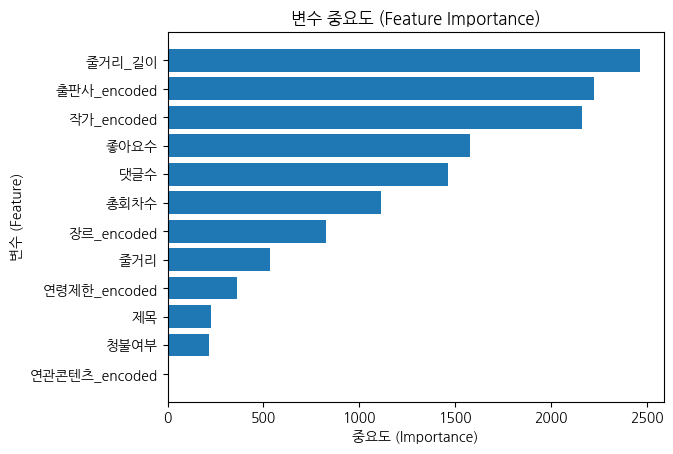

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')  # 나눔고딕 폰트 설정
plt.rc('axes', unicode_minus=False)   # 음수 기호(-) 깨짐 방지

# 최적 모델 학습
best_model.fit(X_train, y_train)

# 변수 중요도 가져오기
feature_importances = best_model.feature_importances_

# 변수 이름 가져오기
feature_names = X_train.columns  # X_train이 DataFrame이라면 컬럼 이름을 그대로 사용

# 변수 중요도 데이터프레임 생성
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 출력
print(importance_df)

# 변수 중요도 시각화
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('중요도 (Importance)')
plt.ylabel('변수 (Feature)')
plt.title('변수 중요도 (Feature Importance)')
plt.gca().invert_yaxis()
plt.show()

In [21]:
good = EDA[EDA['평점'] == 1 ]
bad = EDA[EDA['평점'] == 0 ]

In [22]:
!apt-get install fonts-nanum -qq

In [34]:
# import os
# import shutil
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm

# # 폰트 캐시 삭제
# font_cache_dir = os.path.expanduser("~/.cache/matplotlib")
# if os.path.exists(font_cache_dir):
#     shutil.rmtree(font_cache_dir)
#     print(f"폰트 캐시 삭제: {font_cache_dir}")

# # 나눔고딕 폰트 설정
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# font_prop = fm.FontProperties(fname=font_path)

# # matplotlib 설정
# plt.rcParams['font.family'] = font_prop.get_name()
# plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
# print(f"설정된 폰트: {plt.rcParams['font.family']}")


폰트 캐시 삭제: /root/.cache/matplotlib
설정된 폰트: ['NanumGothic']


In [31]:
!ls /usr/share/fonts/truetype/nanum

NanumBarunGothicBold.ttf  NanumGothicCodingBold.ttf  NanumMyeongjoBold.ttf  NanumSquareRoundB.ttf
NanumBarunGothic.ttf	  NanumGothicCoding.ttf      NanumMyeongjo.ttf	    NanumSquareRoundR.ttf
NanumGothicBold.ttf	  NanumGothic.ttf	     NanumSquareB.ttf	    NanumSquareR.ttf


In [27]:
good

,제목,평점,좋아요수,댓글수,연관콘텐츠,장르,작가,출판사,연령제한,줄거리,총회차수,청불여부,원제목,줄거리_길이
0,6,1,28,82,No,현판,황규영,글쓰는 사람들,전체 이용가,8,2,0,천둥새,107
3,3,1,14,23,No,로맨스,임은정(아사렐라),로맨스토리(북큐브 제공),청소년 이용불가,8,1,1,20살 서툰 유혹 [단행본],808
4,2,1,15,2,No,로맨스,박선경,라떼북,청소년 이용불가,5,2,1,플레이 레이디 [단행본],536
7,4,1,39,15,No,로맨스,김은희,도서출판 동아,청소년 이용불가,5,1,1,아내의 비밀 [단행본],412
8,0,1,22,41,No,판타지,남수아,에피루스,전체 이용가,5,8,0,질풍의 로젠크란츠,737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13066,0,1,27,27,No,로맨스,바나,스칼렛,청소년 이용불가,8,1,1,사고쳤어요 [단행본],324
13067,3,1,25,59,No,판타지,최정연,도서출판 청어람,전체 이용가,1,6,0,불사왕 [단행본],135
13072,0,1,50,23,No,로맨스,송민선,로맨스토리(북큐브 제공),청소년 이용불가,2,1,1,터닝 (Turning) [단행본],303
13076,0,1,4,0,No,로맨스,에클레어,라떼북,청소년 이용불가,5,2,1,예뻐 죽겠다 [단행본],766


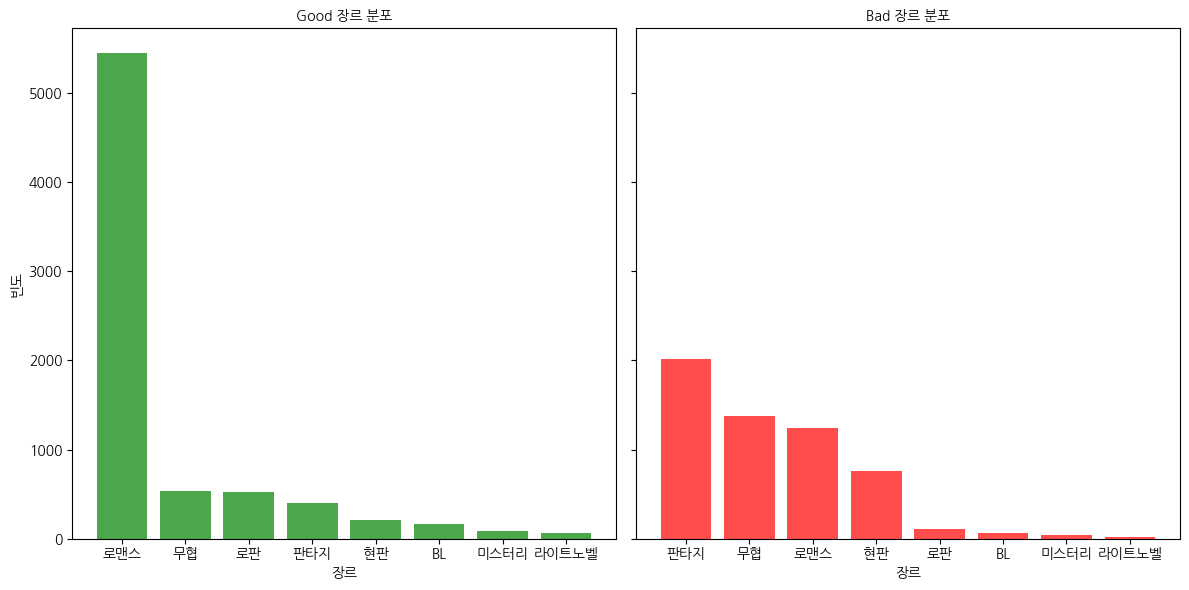

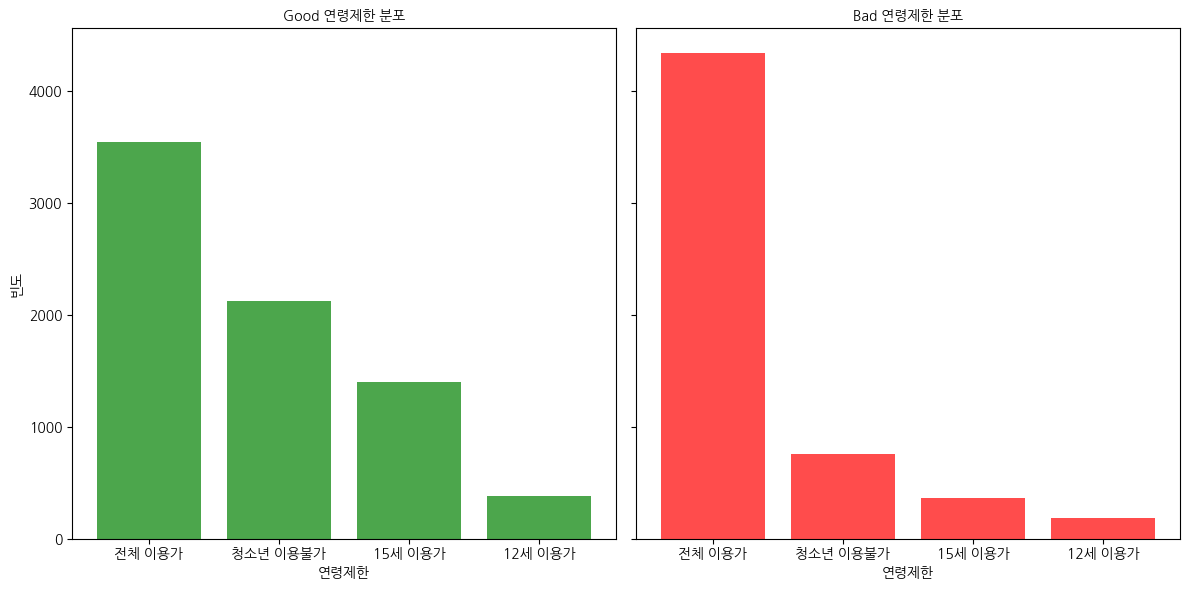

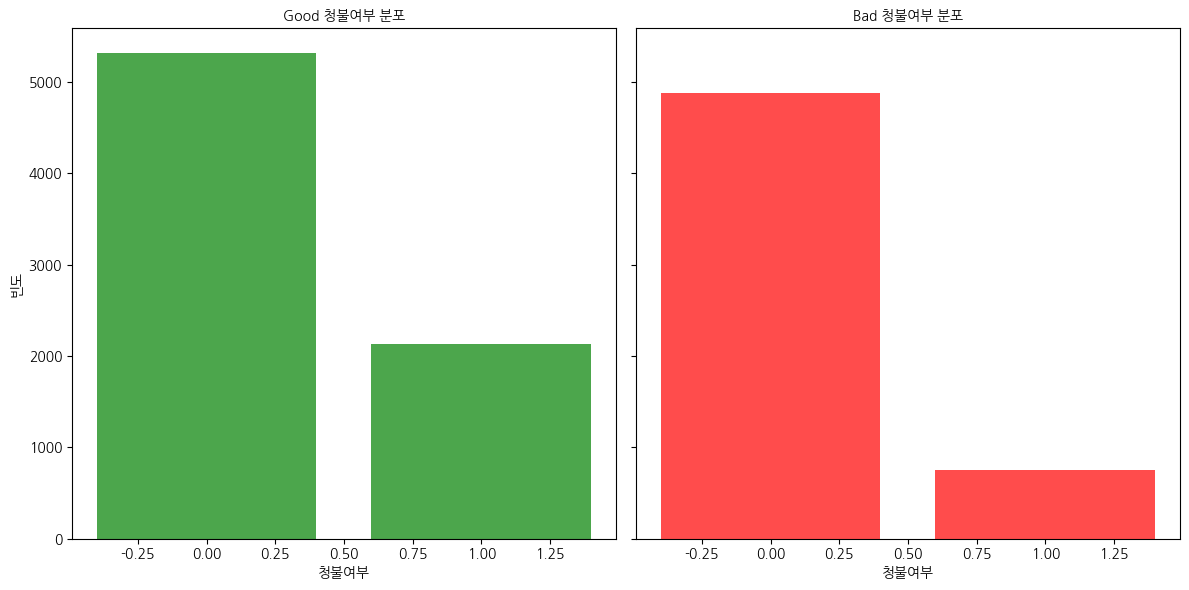

In [34]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def visualize_genre(good, bad, column_name="장르"):
    """
    범주형 데이터를 시각화하는 함수.

    Parameters:
        good (DataFrame): Good 데이터프레임
        bad (DataFrame): Bad 데이터프레임
        column_name (str): 시각화할 열 이름 (기본값: '장르')

    Returns:
        None: 그래프를 출력합니다.
    """
    # 한글 폰트 설정
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 나눔고딕 폰트 경로
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

    # 범주형 데이터의 빈도 계산
    good_counts = good[column_name].value_counts()
    bad_counts = bad[column_name].value_counts()

    # Figure와 Subplot 설정
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # 1행 2열, y축 공유

    # 첫 번째 막대그래프 (Good)
    axes[0].bar(good_counts.index, good_counts.values, color='green', alpha=0.7)
    axes[0].set_title(f'Good {column_name} 분포', fontproperties=font_prop)
    axes[0].set_xlabel(column_name, fontproperties=font_prop)
    axes[0].set_ylabel('빈도', fontproperties=font_prop)

    # 두 번째 막대그래프 (Bad)
    axes[1].bar(bad_counts.index, bad_counts.values, color='red', alpha=0.7)
    axes[1].set_title(f'Bad {column_name} 분포', fontproperties=font_prop)
    axes[1].set_xlabel(column_name, fontproperties=font_prop)

    # 레이아웃 조정
    plt.tight_layout()
    plt.show()


# 함수 사용 예제

visualize_genre(good, bad, column_name="장르")
visualize_genre(good, bad, column_name="연령제한")
visualize_genre(good, bad, column_name="청불여부")
